## load depencencies

In [23]:
import os
import librosa
import numpy as np
import scipy.ndimage as ndimage
import pickle

## set configs

In [24]:
CONFIGS = [
    {'name': 'small',   'k': 5,  't': 5},
    {'name': 'medium',  'k': 15, 't': 15},
    {'name': 'large',   'k': 40, 't': 40},
    {'name': 'best_v1', 'k': 12, 't': 15}, # Etwas mehr Details in der Frequenz
    {'name': 'best_v2', 'k': 18, 't': 15}, # Etwas robuster gegen Frequenz-Schwankungen
    {'name': 'best_v3', 'k': 15, 't': 20}  # Größerer zeitlicher Filter
]

## create constellation map and save in a sparse matrix

In [25]:
def get_peaks(Y, k, t):
    # Effiziente Constellation Map
    size = (2*k + 1, 2*t + 1)
    result = ndimage.maximum_filter(Y, size=size, mode='constant')
    cmap = (Y == result) & (Y > 0.01)
    
    # WICHTIG: Wir speichern nur die Indizes (sparase representation)
    return np.argwhere(cmap)

## initialize data base and loop over all audio tracks

In [26]:
# Initialisierung der Datenbank
database = {cfg['name']: {} for cfg in CONFIGS}

audio_folder = 'data/40'
song_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]

# Doppelte Schleife: 
for song in song_files:
    path = os.path.join(audio_folder, song)
        
    # die ersten 30 Sekunden laden
    y, sr = librosa.load(path, duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))

    for cfg in CONFIGS: 
        # Berechnung
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        
        # Speichern im Dictionary
        database[cfg['name']][song] = peaks

To reduce computation resources needed, the magnitude-spektogram Y is calculated once per audio track and the constellation maps for each six configurations is computed afterwards directly, before loading the next audio track. 

## plot small, medium and large configuration

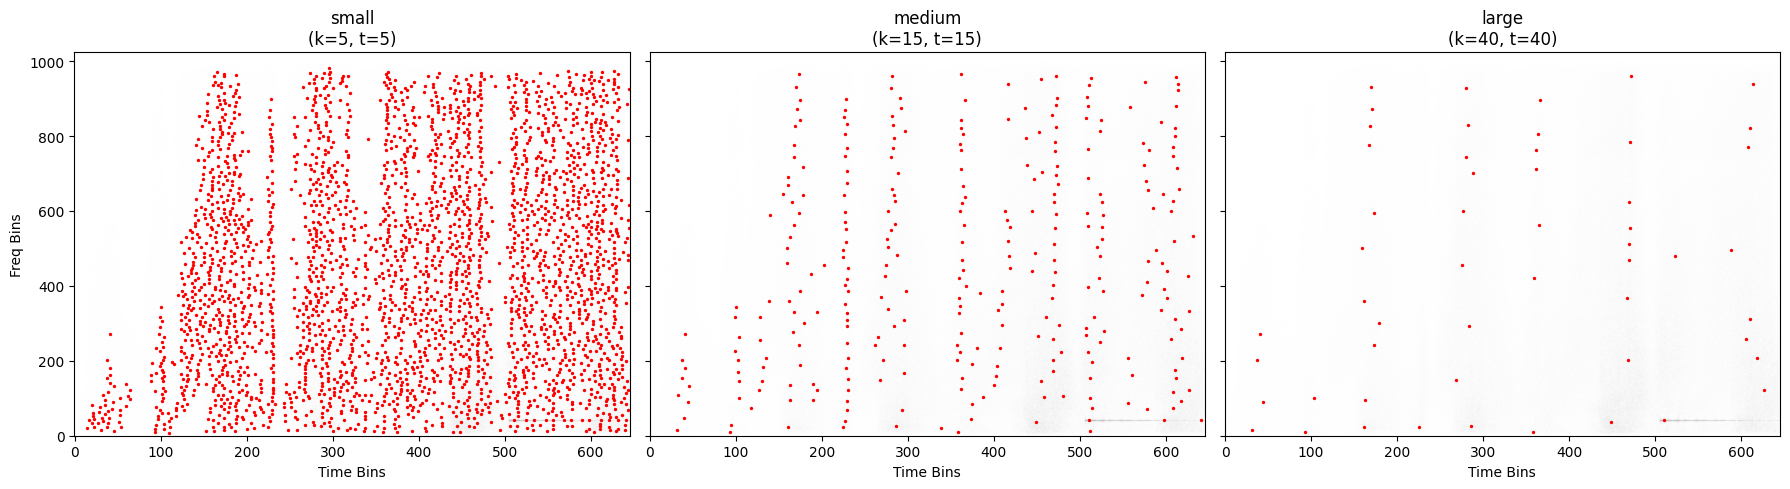

In [35]:
import matplotlib.pyplot as plt

def plot_exploration(filename, configs_to_show):
    # Lade den Song einmal
    y, sr = librosa.load("data/40/2240.mp3", duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))
    Y_log = np.log(1 + 10 * Y) # Log-Skala für bessere Sichtbarkeit des Spektrogramms
    
    fig, axes = plt.subplots(1, len(configs_to_show), figsize=(18, 5), sharey=True)
    
    for ax, cfg in zip(axes, configs_to_show):
        # C-Map berechnen
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        
        # Hintergrund: Spektrogramm (dezent)
        ax.imshow(Y_log, origin='lower', aspect='auto', cmap='gray_r', alpha=0.3)
        
        # Vordergrund: Die Peaks der Constellation Map
        ax.scatter(peaks[:, 1], peaks[:, 0], s=2, c='red', marker='o')
        
        ax.set_title(f"{cfg['name']}\n(k={cfg['k']}, t={cfg['t']})")
        ax.set_xlabel('Time Bins')
    
    axes[0].set_ylabel('Freq Bins')
    plt.tight_layout()
    plt.show()

# Aufruf für die ersten 3 Configs
plot_exploration('dein_test_song.mp3', CONFIGS[:3])

You can see that **small window size** captures many peaks and is very dense overall. Many details are captured but, this leads to high computation and potentially many false positives, because too much noise is interpreted as peaks. 
The **medium config** results in vertical lines, which typically represent the onsets. This is a promising configuration for querying. 
The **large config** results in a very sparse representation, where only the strongest peaks are caputred. Here the risk is high for short audio tracks or noisy tracks, that no matches are found, because of missing informations. 

Based on the visual analysis of these three configs, we made variations of the promising medium config to balance and optimize the parameters even more. With $\kappa=18$ (best_v2) we test a less granular frequency filter, in the hope to make the map even clearer. $\tau=20$ (best_v3), makes the time steps bigger and looks if this helps for a better identification of the peaks.

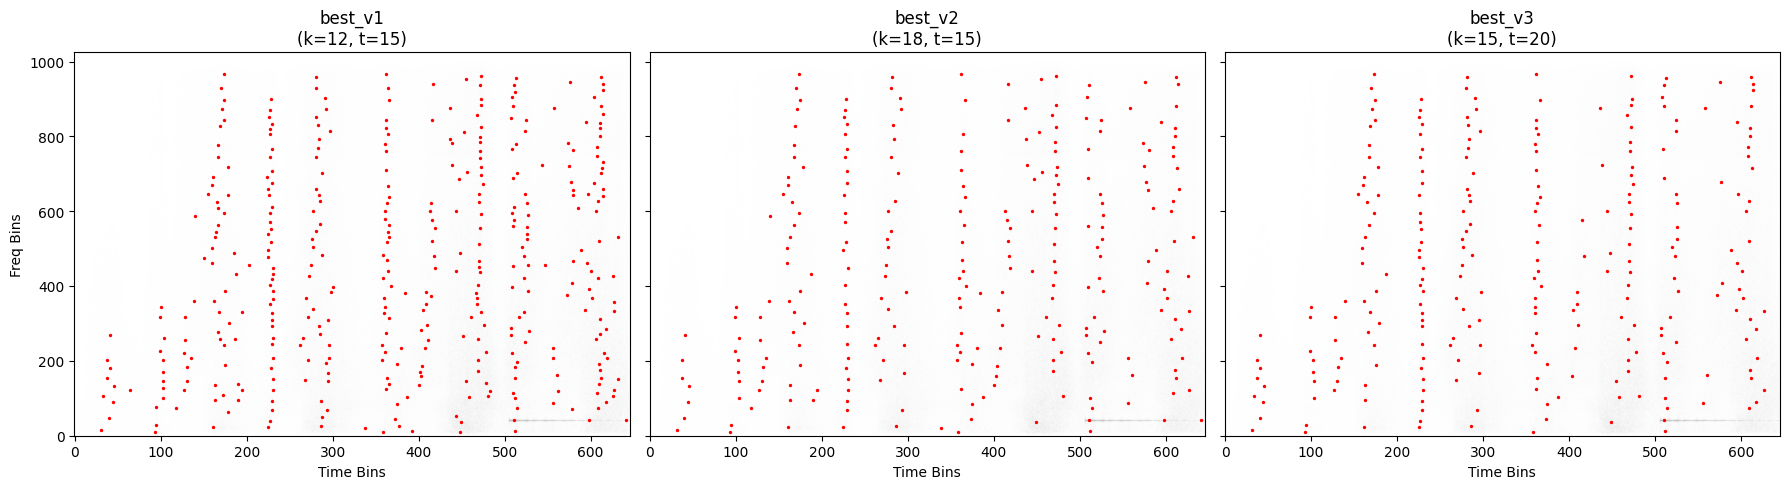

In [36]:
plot_exploration('dein_test_song.mp3', CONFIGS[3:])

best_v1 ($\kappa=12$): Testing a slightly higher frequency density. <br>
best_v2 ($\kappa=18$): Testing more frequency isolation for cleaner peaks. <br>
best_v3 ($\tau=20$): Testing a larger time context to focus on only the most significant temporal events.

## save in pickle file

In [37]:
# 2. Speichern der gesamten Datenbank
with open('music_database_full.pkl', 'wb') as f:
    pickle.dump(database, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Caputred in database!")

with open('music_database_full.pkl', 'rb') as f:
    database = pickle.load(f)

Caputred in database!


All calculated maps for the 500+ tracks and 6 configurations were stored in a dictionary-based structure (Pickle format) to allow unambiguous mapping between files and representations.

Lade Datenbank: music_database_full.pkl ...
Gefundene Konfigurationen: ['small', 'medium', 'large', 'best_v1', 'best_v2', 'best_v3']
 -> 'small': 574 Songs gespeichert.
 -> 'medium': 574 Songs gespeichert.
 -> 'large': 574 Songs gespeichert.
 -> 'best_v1': 574 Songs gespeichert.
 -> 'best_v2': 574 Songs gespeichert.
 -> 'best_v3': 574 Songs gespeichert.


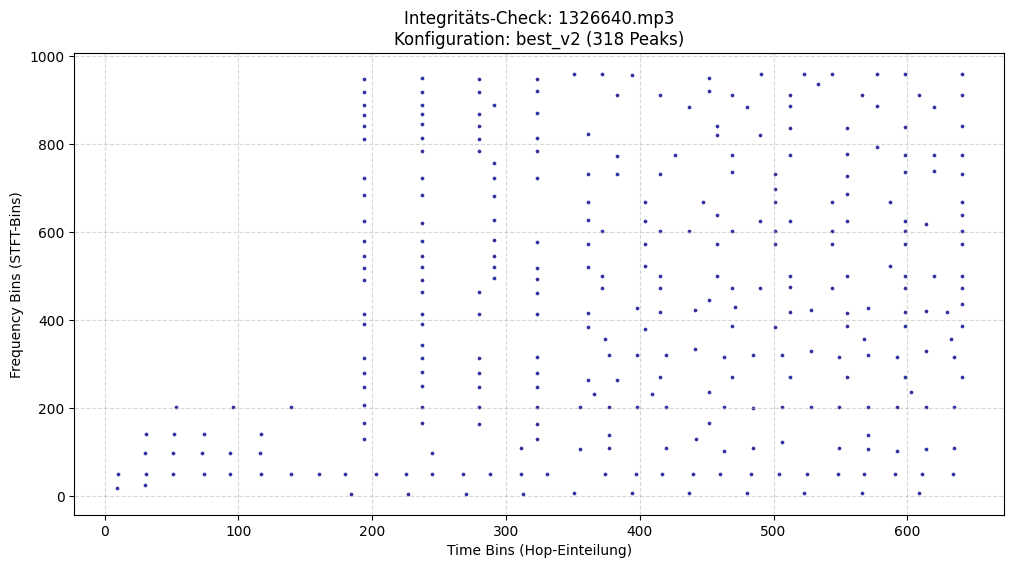

In [39]:
import random
def verify_database_integrity(pickle_path):
    # 1. Datenbank laden
    print(f"Lade Datenbank: {pickle_path} ...")
    with open(pickle_path, 'rb') as f:
        db = pickle.load(f)
    
    # 2. Struktur-Check
    configs = list(db.keys())
    print(f"Gefundene Konfigurationen: {configs}")
    
    for cfg in configs:
        num_songs = len(db[cfg])
        print(f" -> '{cfg}': {num_songs} Songs gespeichert.")
    
    # 3. Zufälliges Sample für Visualisierung auswählen
    random_cfg = random.choice(configs)
    all_songs = list(db[random_cfg].keys())
    
    if not all_songs:
        print("Fehler: Keine Songs in der Datenbank gefunden!")
        return
    
    random_song = random.choice(all_songs)
    peaks = db[random_cfg][random_song]
    
    # 4. Visualisierung
    plt.figure(figsize=(12, 6))
    # peaks[:, 1] ist die Zeit (x), peaks[:, 0] ist die Frequenz (y)
    plt.scatter(peaks[:, 1], peaks[:, 0], s=3, c='darkblue', alpha=0.7)
    
    plt.title(f"Integritäts-Check: {random_song}\nKonfiguration: {random_cfg} ({len(peaks)} Peaks)")
    plt.xlabel("Time Bins (Hop-Einteilung)")
    plt.ylabel("Frequency Bins (STFT-Bins)")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Optional: Y-Achse invertieren, damit niedrige Frequenzen unten sind (wie im Spektrogramm)
    # plt.gca().invert_yaxis() 
    
    plt.show()

# Funktion aufrufen
verify_database_integrity('music_database_full.pkl')